In [1]:
import scvelo as scv
import numpy as np  
import matplotlib.pyplot as plt

import anndata

import sys
sys.path.append("..")


import cellpath as cp
import cellpath.visual as visual
import cellpath.benchmark as bmk 
import cellpath.de_analy as de


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

## Meta-cell construction

In [2]:
# read in simulated dataset
# adata = anndata.read_h5ad("./sim_data/Symsim/multi_cycles_400_rand1_clust.h5ad")
adata = anndata.read_h5ad("../sim_data/Symsim/multi_cycles_200_rand1_clust.h5ad")

In [3]:
cellpath_obj = cp.CellPath(adata = adata)
# self, n_clusters = None, include_unspliced = True, standardize = True, **kwarg
cellpath_obj.meta_cell_construction(n_clusters = 100, include_unspliced = True, standardize = True)
cellpath_obj.meta_cell_graph(k_neighs = 5, pruning = False, scaling = 4, distance_scalar = 0.5)
cellpath_obj.meta_paths_finding(threshold = 0.5, cutoff_length = None, length_bias = 0.5, max_trajs = 30)
cellpath_obj.first_order_pt(num_trajs = None)

Already conducted clustering
Meta-cell constructed
Meta-cell level neighborhood graph constructed
conduct quality control
selected path (starting_ending):
start_end:  13_62 , len:  59 newly covered: 59
start_end:  34_88 , len:  59 newly covered: 4
start_end:  96_87 , len:  49 newly covered: 8
start_end:  13_92 , len:  58 newly covered: 1
Finished
Cell-level pseudo-time inferred


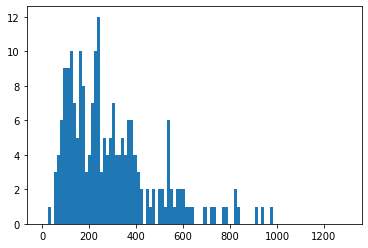

In [4]:
visual.weight_histogram(cellpath_obj, resolution = 100)

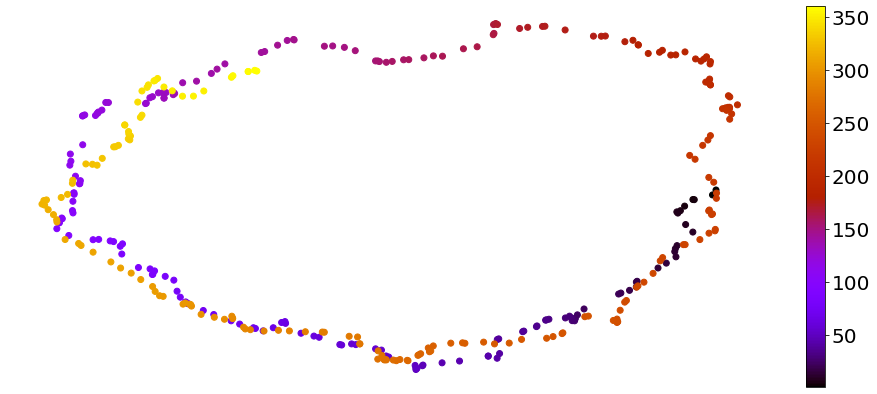

In [5]:
visual.plot_data(cellpath_obj, basis = "pca", figsize = (15,7), save_as = None)

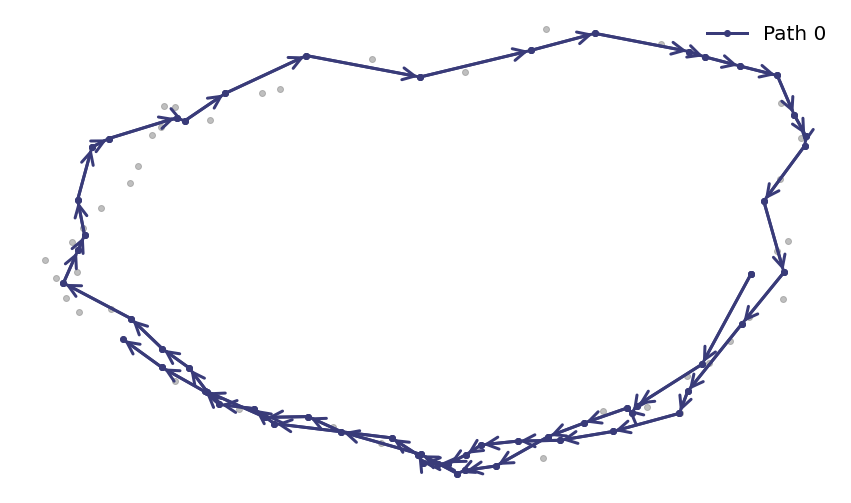

In [6]:
visual.meta_traj_visual(cellpath_obj, basis = "pca", trajs = 1, figsize = (15,9), save_as = None)

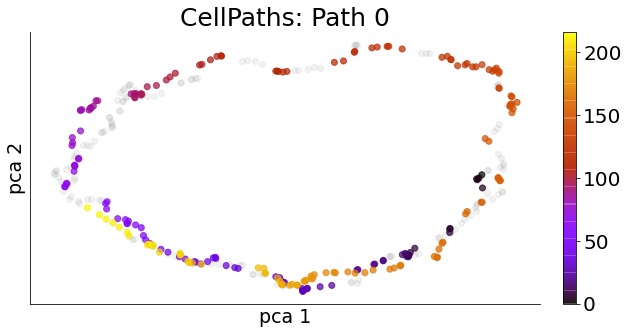

In [8]:
visual.first_order_approx_pt(cellpath_obj, basis = "pca", trajs = 1, figsize= (10,5), save_as = None)

# Benchmark
## Kendall-tau test
### CellPaths

In [11]:
non_zeros = {}
pt_pred = {}
pt_true = {}
kt = {}
for icol, col in enumerate(pseudo_order.columns):
    non_zeros[col] = np.where(~np.isnan(pseudo_order[col].values.squeeze()))[0]
    pt_pred[col] = pseudo_order.iloc[non_zeros[col], icol].values.squeeze()
    pt_true[col] = adata.obs["sim_time"].iloc[non_zeros[col]].values
    kt[col] = bmk.kendalltau(pt_pred[col], pt_true[col])

In [12]:
kt

{&#39;traj_0&#39;: 0.9956719993817141}

In [13]:
X_pca = adata.obsm['X_pca']

n_clusters = 10
init = "k-means++"
n_init = 10
max_iter = 300
tol = 0.0001
kmeans = KMeans(n_clusters, init, n_init, max_iter, tol)
groups = kmeans.fit_predict(X_pca)
meta_data = adata.obs
meta_data['groups'] = groups

Text(0.5, 1.0, &#39;slingshot clusters&#39;)

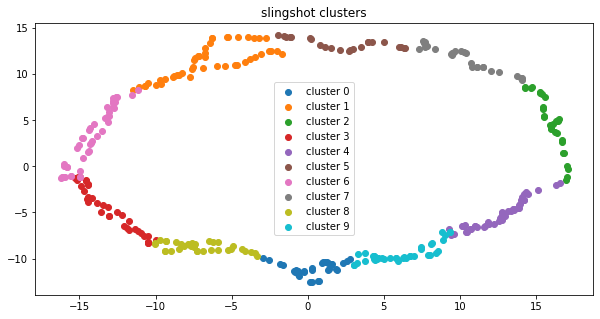

In [14]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()
c_range = [eval(x) if isinstance(x, str) else x for x in adata.obs['sim_time']]
clusters = int(np.max(groups)+1)
for i in range(clusters):
    sub_cells = np.where(groups == i)[0]
    progression = ax.scatter(X_pca[sub_cells,0], X_pca[sub_cells,1], cmap = plt.get_cmap('Pastel1'))
    # progression = ax.scatter(X_umap[sub_cells,0], X_umap[sub_cells,1], cmap = plt.get_cmap('Pastel1'))

ax.legend(['cluster '+ str(i) for i in range(clusters)])
ax.set_title("slingshot clusters")
# fig.savefig("./syn_results/dataset1/slingshot_clust.pdf")

In [15]:
X_pca_df = pd.DataFrame(index=[str(x) for x in range(X_pca.shape[0])], columns= np.arange(2), data = X_pca[:,0:2])
# scprep.run.install_bioconductor('slingshot')
results = scprep.run.Slingshot(X_pca_df, meta_data['groups'], start_cluster = 1)

R[write to console]: Using full covariance matrix


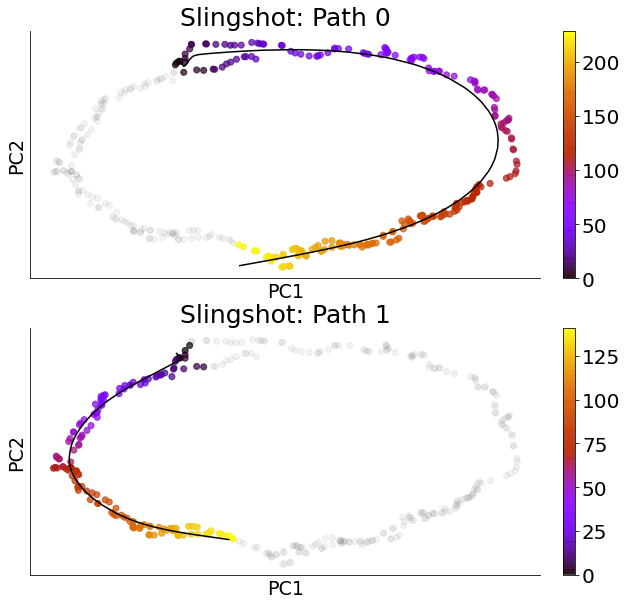

In [16]:
kt_slingshot = visual.slingshot_visual(adata,  results, basis= "pca", figsize=(10,10), save_as = None)# "./sim_results/Symsim/multiple_cycles/200/slingshot_result5.pdf")

In [17]:
kt_slingshot

{&#39;traj_0&#39;: 0.17885119997151508, &#39;traj_1&#39;: -0.5107148266547666}

# velocity DPT

In [ ]:
adata = anndata.read_h5ad("./sim_data/Symsim/multi_cycles_200_rand5.h5ad")
scv.tl.velocity_pseudotime(adata)

In [19]:
y_vdpt = adata.obs['velocity_pseudotime'].values
vdpt_pred  = {}
kt_vdpt = {}
for icol, col in enumerate(pseudo_order.columns):
    non_zeros[col] = np.where(~np.isnan(pseudo_order[col].values.squeeze()))[0]
    vdpt_pred[col] = y_vdpt[non_zeros[col]]
    kt_vdpt[col] = bmk.kendalltau(vdpt_pred[col], pt_true[col])

kt_vdpt

Text(0.5, 1.0, 'velocity diffusion pseudo-time: Path 0')

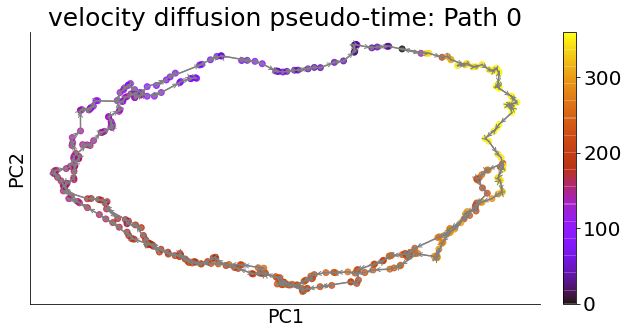

In [37]:
# X_pca = adata.obsm["X_pca"]
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()

for i in range(X_pca.shape[0]-1):
    line = ax.plot(X_pca[i:(i+2), 0], X_pca[i:(i+2), 1], 'gray', '-', alpha = 1)
    visual.add_arrow(line[0], size = 10)

pic = ax.scatter(X_pca[:,0],X_pca[:,1], alpha = 0.7, cmap = 'gnuplot', c = y_vdpt * X_pca.shape[0])
ax.tick_params(axis = "both", direction = "out", labelsize = 16)
ax.set_xlabel("PC1", fontsize = 19)
ax.set_ylabel("PC2", fontsize = 19)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = ax)
cbar.ax.tick_params(labelsize = 20)
ax.set_title("velocity diffusion pseudo-time: Path " + str(0), fontsize = 25)

# fig.savefig("./sim_results/Symsim/multiple_cycles/400/vdpt.pdf", bbox_inches = "tight")

## scvelo Latent times

In [22]:
adata = anndata.read_h5ad("./sim_data/Symsim/multi_cycles_200_rand5.h5ad")
scv.tl.recover_dynamics(adata)
# or recover_latent_time, the functionality is the same
scv.tl.latent_time(adata)
lt = adata.obs["latent_time"].values

recovering dynamics
    finished (0:01:16) --&gt; added 
    &#39;fit_pars&#39;, fitted parameters for splicing dynamics (adata.var)
computing terminal states
    identified 1 region of root cells and 1 region of end points 
    finished (0:00:00) --&gt; added
    &#39;root_cells&#39;, root cells of Markov diffusion process (adata.obs)
    &#39;end_points&#39;, end points of Markov diffusion process (adata.obs)
computing latent time
    finished (0:00:00) --&gt; added 
    &#39;latent_time&#39;, shared time (adata.obs)


In [25]:
adata2 = anndata.read_h5ad("./sim_data/Symsim/multi_cycles_200_rand5.h5ad")
scv.tl.recover_dynamics(adata2)
scv.tl.recover_latent_time(adata2)

recovering dynamics
    finished (0:01:15) --&gt; added 
    &#39;fit_pars&#39;, fitted parameters for splicing dynamics (adata.var)
computing terminal states
    identified 1 region of root cells and 1 region of end points 
    finished (0:00:00) --&gt; added
    &#39;root_cells&#39;, root cells of Markov diffusion process (adata.obs)
    &#39;end_points&#39;, end points of Markov diffusion process (adata.obs)
computing latent time
    finished (0:00:00) --&gt; added 
    &#39;latent_time&#39;, shared time (adata.obs)


Text(0.5, 1.0, &#39;velocity diffusion pseudo-time: Path 0&#39;)

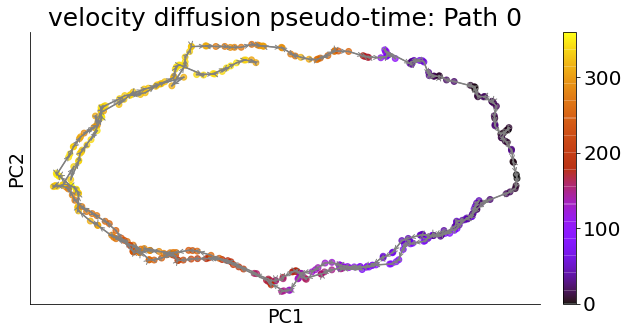

In [23]:
# X_pca = adata.obsm["X_pca"]
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()

for i in range(X_pca.shape[0]-1):
    line = ax.plot(X_pca[i:(i+2), 0], X_pca[i:(i+2), 1], 'gray', '-', alpha = 1)
    visual.add_arrow(line[0], size = 10)

pic = ax.scatter(X_pca[:,0],X_pca[:,1], alpha = 0.7, cmap = 'gnuplot', c = lt * X_pca.shape[0])
ax.tick_params(axis = "both", direction = "out", labelsize = 16)
ax.set_xlabel("PC1", fontsize = 19)
ax.set_ylabel("PC2", fontsize = 19)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

cbar = fig.colorbar(pic, fraction=0.046, pad=0.04, ax = ax)
cbar.ax.tick_params(labelsize = 20)
ax.set_title("velocity diffusion pseudo-time: Path " + str(0), fontsize = 25)

# fig.savefig("./sim_results/Symsim/multiple_cycles/400/vdpt.pdf", bbox_inches = "tight")

## Result boxplot

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# CellPaths, vdpt, slingshot
kts_array = [[0.9956477214541731, 0.9957000570400597, 0.9954356181934657, -0.25207318678425694, 0.9955192709322193], [-0.24621922334743476, 0.4880428166473475, -0.3215500159416454, 0.4041433452041773, 0.36585252002902147, -0.3558598393558372, -0.3265450243382565, 0.3483877203444393, 0.32903642241733677, -0.45874331365079574], [-0.019459736428839112, -0.1660486658959716, 0.3103455878625159, 0.0008354694806474525]]

In [21]:
max_kts = [max(x) for x in kts_array]
min_kts = [min(x) for x in kts_array]
# my_formatted_list = [ '%.2f' % elem for elem in my_list ]
max_kts_text = ['%.4f' % x for x in max_kts]
min_kts_text = ['%.4f' % x for x in min_kts]

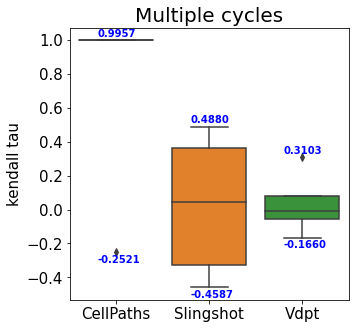

In [44]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
bp = sns.boxplot(data = kts_array, ax = ax)#, x = ["CellPaths", "slingshot", "vdpt"])
ax.set_xticklabels(["CellPaths", "Slingshot", "Vdpt"],fontsize = 15)
ax.set_ylabel("kendall tau", fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_title("Multiple cycles", fontsize = 20)
for xtick in bp.get_xticks():
    bp.text(xtick - 0.2, max_kts[xtick]+ 0.02, max_kts_text[xtick], size='medium',color = "b", weight='semibold')
    bp.text(xtick - 0.2, min_kts[xtick]- 0.06, min_kts_text[xtick], size='medium',color = "b", weight='semibold')
fig.savefig("./boxplot.pdf", bbox_inches = "tight")